In [1]:
from flask import Flask, render_template, request, redirect, url_for, flash
from werkzeug.utils import secure_filename
from PIL import Image
import psycopg2
import torch
import ultralytics
import os,shutil,random,tqdm,json


In [69]:
#### 샘플 데이터 추출

sp = 'Test'
path = 'e:/p2_data/120personal_veh/01data/2Validation/'+sp+'_json/'+sp+'2_ann.json'

with open(path, 'r') as file:
    data = json.load(file)

classes = ['Motorcycle_Pedestrian Road Violation', 'Motorcycle_No Helmet', 'Motorcycle_Jaywalking', 
'Motorcycle_Signal Violation', 'Motorcycle_Stop Line Violation', 'Motorcycle_Crosswalk Violation', 
'Bicycle_Pedestrian Road Violation', 'Bicycle_No Helmet', 'Bicycle_Jaywalking', 
'Bicycle_Signal Violation', 'Bicycle_Stop Line Violation', 'Bicycle_Crosswalk Violation', 
'Kickboard_Pedestrian Road Violation', 'Kickboard_No Helmet', 'Kickboard_Jaywalking', 
'Kickboard_Signal Violation','Kickboard_Crosswalk Violation', 'Kickboard_Passenger Violation']


annotations = data['annotations']
maxlen = len(annotations)
searched_list=[]
ban_list = ['T008037_072_0012_C_D_F_0.jpg',
'T008037_067_0096_C_D_F_0.jpg',
'T008037_072_0156_C_D_F_0.jpg',
'T008037_009_0020_C_D_F_0.jpg',
'T008037_068_0040_C_D_F_0.jpg', 
'T008037_068_0040_C_D_F_0.jpg',
'T008037_068_0040_C_D_F_0.jpg',
'T015350_007_0378_C_D_F_1.jpg',
'T008037_100_0060_C_D_F_0.jpg',
'T008037_066_0126_C_D_F_0.jpg',
'T008037_066_0126_C_D_F_0.jpg',
'T008037_067_0160_C_D_F_0.jpg',
'T008037_066_0144_C_D_F_0.jpg',
'T008037_066_0144_C_D_F_0.jpg',
'T008034_001_0144_B_D_F_0.jpg', 
'T008037_068_0100_C_D_F_0.jpg', 
'T008037_068_0100_C_D_F_0.jpg',
'T007931_000_0070_B_D_F_0.jpg']

# label_dict = {'0':1,'1':2,'2':3,'3':4,'4':5,'5':6,'6':9,'7':10,'8':11,
#               '9':12,'10':13,'11':14,'12':17,'13':18,'14':19,'15':20,
#               '16':21,'17':22
#               }

label_dict = {0:1,1:2,2:3,3:4,4:5,5:6,6:9,7:10,8:11,
              9:12,10:13,11:14,12:17,13:18,14:19,15:20,
              16:21,17:22
              }

to_save_dict = {i:[] for i in label_dict.values()}
tot_dict = {i:[] for i in label_dict.values()}

for i in range(maxlen):
    idx = random.randint(0,maxlen-1)
    label = annotations[idx]['category_id']
    label = label_dict[label]
    
    img_id = annotations[idx]['image_id']
    if (img_id in searched_list):
        continue
    else:
        filename = data['images'][img_id-1]['file_name']
        if filename in ban_list:
            continue
        else:
            tot_dict[label].append([data['images'][img_id-1],annotations[idx]])
            searched_list.append(img_id)

for i in label_dict.values():
    print(i,len(tot_dict[i]))
    to_save_dict[i] = random.sample(tot_dict[i],10)


with open('sample_data.json', 'w') as file:
    json.dump(to_save_dict,file)


1 467
2 57
3 22
4 312
5 469
6 28
9 263
10 454
11 106
12 76
13 51
14 423
17 136
18 125
19 38
20 48
21 73
22 60


In [4]:
#### yolov8 yaml파일, txt 파일 생성.

with open('datasets/sample/sample_data.json', 'r') as file1:
    data1= json.load(file1)
# with open('data/sample/yolov8_0_validation.txt', 'w') as file2:
#     data2 = json.load(file2)


val_txt_lines = []
img_txt_line = []
for label_key in data1.keys():
    list = data1[label_key]
    for image_one in list:
        image_info = image_one[0]
        image_anno = image_one[1]

        image_conntent = f"{image_info['file_name']}"
        val_txt_lines.append(image_conntent)
        img_txt_line = f"{label_key} {image_anno['bbox'][0]},{image_anno['bbox'][1]},{image_anno['bbox'][2]},{image_anno['bbox'][3]}"
        # val_txt_lines.append(label_key)
        # val_txt_lines.append(image_anno['bbox'])
        with open("datasets/sample/labels/"+image_conntent.split('.')[0]+'.txt', "w") as img_txt:
            img_txt.write(img_txt_line)

with open("val.txt", "w") as val_txt_file:
    val_txt_file.write('\n'.join(val_txt_lines))
        


In [2]:
#### 파일 복제

with open('datasets/sample/sample_data.json', 'r') as file1:
    data1= json.load(file1)
# with open('data/sample/yolov8_0_validation.txt', 'w') as file2:
#     data2 = json.load(file2)

source_directory = 'e:/p2_data/120personal_veh/01data/2Validation/test'
target_directory = 'datasets/sample/image'
file_list = []

for label_key in data1.keys():
    list = data1[label_key]
    for image_one in list:
        image_info = image_one[0]
        file_name = image_info['file_name']
        source_path = source_directory + '/' + file_name
        target_path = target_directory + '/' + file_name       # 복제할 파일의 대상 경로
        shutil.copy(source_path, target_path)



In [11]:
from pathlib import Path

def check_empty_or_whitespace_filenames(folder_path):
    folder = Path(folder_path)

    for file_path in folder.iterdir():
        if file_path.is_file():
            filename = file_path.name.strip()  # 공백 제거
            if not filename:
                print(f"Empty or whitespace filename found: {file_path}")


target_folder = "datasets\sample\images"
check_empty_or_whitespace_filenames(target_folder)

In [11]:
from ultralytics import YOLO

model = YOLO('datasets\\sample\\model\\yolov8.pt')

frame = "datasets/sample/ex.mp4"
model.predict(source = frame,
                        save=True,
                        save_txt=True,
                        conf=0.1,
                        iou=0.7,
                        agnostic_nms=True,
                        device='cpu',
                        stream=True,
                        )
# print(results)
# model.val(data='c:/Users/user/Project2/CatchAll/datasets/sample/val.yaml')
# model.val(data='datasets/sample/val.yaml')

# metrics = model.val()
# results = model.predict(source = im1,save = True)
# results = model(dir)

# results


<generator object BasePredictor.stream_inference at 0x0000016B288DCF20>

In [13]:
import cv2
from ultralytics import YOLO

# YOLO 모델 초기화
yolo = YOLO('datasets\\sample\\model\\yolov8.pt')

# 비디오 스트림 열기
video_stream = cv2.VideoCapture('datasets/sample/ex.mp4')  # 웹캠 사용 시에는 0 또는 1로 설정

while True:
    ret, frame = video_stream.read()  # 프레임 읽기

    if not ret:
        break

    # 객체 감지 및 예측
    detection_results = yolo.predict(frame, stream=True)

    # 결과 시각화
    visualized_frame = yolo.visualize(frame, detection_results)

    # 결과 출력
    cv2.imshow('YOLO Object Detection', visualized_frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):  # 'q' 키를 누르면 종료
        break

video_stream.release()
cv2.destroyAllWindows()

AttributeError: 'YOLO' object has no attribute 'visualize'. See valid attributes below.

    YOLO (You Only Look Once) object detection model.
    

In [2]:

"""
coco annotation을 YOLOv5 format으로 변경해누즌 함수
Bounding Box와 라벨만 변환
"""

FILE_PATH = 'datasets/sample/label'
file__ ='datasets/sample/sample_data.json'
# json dict가 아니라 경로로 되있으면 dict로 변환

with open(file__, 'r') as f:
    file = json.load(f)



# image_id 별로 annotation추가 (string형식)


for label_key in file.keys():
    list = file[label_key]
    yolo_annots = {}
    file_images = []
    for dd in tqdm.tqdm(list, desc='annot처리중'):
        annot = dd[1]
        file_images.append(dd[0])
        img_id = annot['image_id']
        # YOLO의 라벨은 0부터 시작한다! COCO는 1부터 시작하므로 1빼기
        label = annot['category_id'] - 1
        left = annot['bbox'][0]
        top = annot['bbox'][1]
        width = annot['bbox'][2]
        height = annot['bbox'][3]

        x = (left + width/2)
        y = (top + height/2)

        width = width
        height = height

        yolo_annots.setdefault(img_id, '')
        yolo_annots[img_id] += f'{label} {x:.5f} {y:.5f} {width:.5f} {height:.5f}\n'

    # image 별로 annotation을 txt파일로 저장
    for image in tqdm.tqdm(file_images, desc='.txt로 저장중'):
        file_name = image['file_name'].replace('.jpg', '.txt')
        img_width = image['width']
        img_height = image['height']
        img_id = image['id']

        # 이미지 크기로 bbox정규화
        reg_annots = ''
        for line in yolo_annots[img_id][:-1].split('\n'):
            ls = line.split(' ')
            ls[1] = float(ls[1]) / img_width
            ls[2] = float(ls[2]) / img_height
            ls[3] = float(ls[3]) / img_width
            ls[4] = float(ls[4]) / img_height

            reg_annots += f'{ls[0]} {ls[1]:.5f} {ls[2]:.5f} {ls[3]:.5f} {ls[4]:.5f}\n'
        reg_annots = reg_annots[:-1]

        # 이미지와 같은 디렉토리에 txt저장
        with open(os.path.join(FILE_PATH,file_name), 'w') as f:
            f.write(reg_annots)




.txt로 저장중: 100%|██████████| 10/10 [00:00<00:00, 2500.18it/s]


.txt로 저장중: 100%|██████████| 10/10 [00:00<00:00, 1999.29it/s]


In [17]:
import xml.etree.ElementTree as ET

# 예제 XML 데이터
with open('index.svg','r') as xfile:
    svg_data = xfile.read()

svg_root = ET.fromstring(svg_data)

# HTML 생성
html = "<div style='width: 100px; height: 100px; border: 1px solid black;'>"
for circle in svg_root.findall(".//{http://www.w3.org/2000/svg}circle"):
    cx = circle.get("cx")
    cy = circle.get("cy")
    r = circle.get("r")
    fill = circle.get("fill")
    html += f"<svg width='{r * 2}' height='{r * 2}'><circle cx='{cx}' cy='{cy}' r='{r}' fill='{fill}' /></svg>"
html += "</div>"

print(html)
with open('newindex.html','w') as nf:
    nf.write(html)



<div style='width: 100px; height: 100px; border: 1px solid black;'><svg width='131.194131.194' height='131.194131.194'><circle cx='296.194' cy='1116.19' r='131.194' fill='#26A6FE' /></svg><svg width='131.194131.194' height='131.194131.194'><circle cx='508.408' cy='1116.19' r='131.194' fill='#60B7FF' /></svg><svg width='131.194131.194' height='131.194131.194'><circle cx='720.621' cy='1116.19' r='131.194' fill='#D8ECFE' /></svg><svg width='131.194131.194' height='131.194131.194'><circle cx='928.722' cy='1116.19' r='131.194' fill='#FD4755' /></svg><svg width='131.194131.194' height='131.194131.194'><circle cx='1131.89' cy='1116.19' r='131.194' fill='#FB2B3A' /></svg></div>


In [2]:
with open('packages.txt', 'r') as f:
    lines = f.readlines()

packages = [line.split()[0] for line in lines if line.strip() and not line.startswith('#')]

with open('requirements.txt', 'w') as f:
    f.write('\n'.join(packages))

In [5]:
import cv2.dnn
import cv2
import PIL
import time,random
import numpy as np
from matplotlib import pyplot as plt

COLORS = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0), (255, 0, 255),
          (0, 255, 255), (255, 128, 0), (128, 0, 255), (0, 255, 128), (255, 128, 128),
          (128, 255, 128), (128, 128, 255), (128, 128, 0), (128, 0, 128), (0, 128, 128),
          (192, 64, 0), (192, 192, 64), (64, 192, 192), (64, 64, 192), (192, 64, 192),
          (64, 192, 64), (255, 192, 128), (128, 255, 192), (128, 192, 255)]

LABEL_NAMES = ['인도', '횡단보도', '자전거 도로', '교차로', '중앙 차선', '안전지대',
              '정지선', '정지선 위반 판별구역', '보행자 신호등 녹색', '보행자 신호등 적색',
              '차량 신호등 녹색', '차량 신호등 적색', '오토바이', '오토바이_보행자도로 통행위반',
              '오토바이_안전모 미착용', '오토바이_무단횡단', '오토바이_신호위반', '오토바이_정지선위반',
              '오토바이_횡단보도 주행위반', '자전거', '자전거 캐리어', '자전거_보행자도로 통행위반',
              '자전거_안전모 미착용', '자전거_무단횡단', '자전거_신호위반', '자전거_정지선위반',
              '자전거_횡단보도 주행위반', '킥보드', '킥보드 캐리어', '킥보드_보행자도로 통행위반',
              '킥보드_안전모 미착용', '킥보드_무단횡단', '킥보드_신호위반', '킥보드_횡단보도 주행위반',
              '킥보드_동승자 탑승위반']

# 아무이미지나 cv2로 불러오는 함수
def choose_img(file=None):
    if not file:
        file = random.choice(glob.glob('data/**/*.jpg')) # data path 커스텀하여 사용
    img_array = cv2.imread(file)
    # BGR 형태로 반환
    return img_array


# ONNX모델과 이미지를 받아서 추론하는 함수
def inference(model:cv2.dnn.Net, img, conf=0.25, nms_th=0.8):
    """
    ONNX 모델 받아서 추론

    returns:
        result : bbox표기된 이미지 (width, height, RGB)
        infer_time : 추론시간 (ms)
    """
    CLASS_NAMES = LABEL_NAMES[12:]
    [height, width, _] = img.shape
    length = max((height, width))
    resized_img = np.zeros((length, length, 3), np.uint8)
    resized_img[0:height, 0:width] = img
    scale = length / 640

    blob = cv2.dnn.blobFromImage(resized_img, scalefactor=1 / 255, size=(640, 640), swapRB=True)
    model.setInput(blob)

    # 출력 형태 (batch, 27, 8400)
    # 여기서 27은 차례대로 bbox좌표4개(x,y,w,h) + 클래스 23개
    # bbox의 숫자 8400개
    t1 = time.time()
    outputs = model.forward()
    t2 = time.time()
    infer_time = round((t2-t1)*1000, 2)

    # 출력형태 (8400, 27)로 변환 후 agnostic NMS 진행
    outputs = outputs[0].transpose()

    boxes = []
    cls_ids = []
    scores = []
    # 기준신뢰도 이상의 box만 추출
    for row in outputs:
        cls_score = row[4:]
        x, y, w, h = row[:4]
        # 최대 최소 및 최대 index 구하기
        minScore, maxScore, (_, minClassLoc), (_, maxClassIndex) = cv2.minMaxLoc(cls_score)
        if maxScore <= conf: # 기준 신뢰도 이하면 버리고 다음 row
            continue
        # left, top, width, height로 변환 (NMSBoxes input format)
        x1, y1= x-(0.5*w), y-(0.5*h)
        boxes.append([x1,y1,w,h])
        scores.append(maxScore)
        cls_ids.append(maxClassIndex)

    # agnostic NMS (선택된 bbox index list출력)
    nms_indices = cv2.dnn.NMSBoxes(boxes, scores, conf, nms_th)

    # 선택된 bbox 그리기 (cv2는 한글폰트 적용 x => PIL 사용)
    img = PIL.Image.fromarray(img[..., ::-1])
    font = PIL.ImageFont.truetype("./batang.ttc", 30)
    draw = PIL.ImageDraw.Draw(img, 'RGB')
    for idx in nms_indices:
        cls_name = CLASS_NAMES[cls_ids[idx]]
        score = scores[idx]
        x1, y1, w, h = np.array(boxes[idx]) * scale # 640*640에 원본스케일 곱하기
        color = COLORS[cls_ids[idx]]

        draw.rectangle((x1,y1,x1+w,y1+h), outline=color, width=5)
        tbbox = draw.textbbox([x1, y1-30], f'{score:.2f} '+cls_name, font=font)
        draw.rectangle(tbbox, fill=color)
        draw.text([x1, y1-30], f'{score:.2f} '+cls_name, font=font, fill='black')

    # 640*640*RGB 행렬및 추론시간(ms) 반환
    result = np.asarray(img)
    return result, infer_time


C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 52628 (\N{HANGUL SYLLABLE CU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 47200 (\N{HANGUL SYLLABLE RON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 44036 (\N{HANGUL SYLLABLE GAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


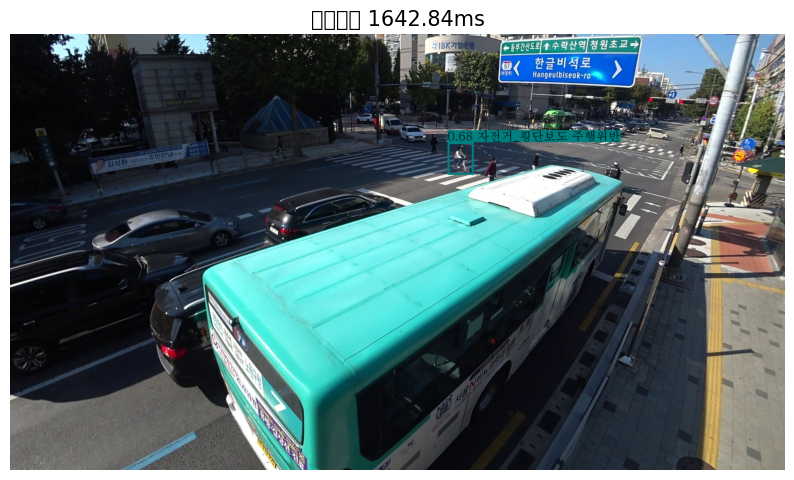

In [24]:
# 사용예시1 사진 추론
onnx_model = cv2.dnn.readNetFromONNX('datasets/sample/model/YOLOv8m.onnx')
test_img = cv2.imread('datasets/sample/t1.jpg')

result, infer_time = inference(onnx_model, test_img, conf=0.5)

plt.figure(figsize=(10,10))
plt.imshow(result)
plt.title(f'추론시간 {infer_time}ms', fontsize=15)
plt.axis('off')
plt.show()

In [7]:
# 비디오 파일 열기
cap = cv2.VideoCapture('datasets/sample/ja.mp4')
onnx_model = cv2.dnn.readNetFromONNX('datasets/sample/model/YOLOv8m.onnx')

# 동영상 저장을 위한 설정
fourcc = cv2.VideoWriter_fourcc(*'XVID')
output_video = cv2.VideoWriter('output_tracking.mp4', fourcc, 30, (int(cap.get(3)), int(cap.get(4))))

while cap.isOpened():
    # 프레임 읽기
    success, frame = cap.read()

    # 성공시 프레임 추론
    if success:
        results, infer_time = inference(onnx_model, frame, conf=0.2)

        # cv2.namedWindow('YOLOv8m Tracking', cv2.WINDOW_NORMAL)
        # cv2.imshow("YOLOv8m Tracking", results[..., ::-1])  # RGB => BGR
        print(f'추론시간 {infer_time}ms')

        # 결과 프레임을 동영상으로 저장
        output_video.write(results)

    # 프레임 전부 읽어들이면 종료
    else:
        cv2.destroyAllWindows()
        cap.release()
        output_video.release()
        break

추론시간 2131.69ms
추론시간 1916.11ms
추론시간 2036.06ms
추론시간 1805.51ms
추론시간 1654.0ms
추론시간 1669.98ms
추론시간 1648.5ms
추론시간 1643.51ms
추론시간 1759.55ms
추론시간 2214.96ms
추론시간 1664.31ms
추론시간 1824.67ms
추론시간 1895.53ms
추론시간 1713.06ms
추론시간 1857.03ms
추론시간 1676.02ms
추론시간 1685.62ms
추론시간 1674.03ms
추론시간 1641.03ms
추론시간 1675.06ms
추론시간 1731.0ms
추론시간 1565.99ms
추론시간 1570.03ms
추론시간 1523.09ms
추론시간 1522.03ms
추론시간 1628.0ms
추론시간 1576.97ms
추론시간 1628.51ms
추론시간 1557.0ms
추론시간 1540.0ms
추론시간 1495.54ms
추론시간 1518.43ms
추론시간 1599.91ms
추론시간 1539.99ms
추론시간 1521.94ms
추론시간 1543.33ms
추론시간 1486.35ms
추론시간 1555.43ms
추론시간 1796.97ms
추론시간 1478.65ms
추론시간 1541.06ms
추론시간 1469.24ms
추론시간 1484.85ms
추론시간 1578.17ms
추론시간 1474.88ms
추론시간 1547.42ms
추론시간 1583.46ms
추론시간 1457.13ms
추론시간 1497.75ms
추론시간 1465.05ms
추론시간 1531.75ms
추론시간 1482.52ms
추론시간 1525.04ms
추론시간 1516.96ms
추론시간 1478.94ms
추론시간 1480.08ms
추론시간 1430.66ms
추론시간 1575.81ms
추론시간 1468.89ms
추론시간 1497.22ms
추론시간 1541.02ms
추론시간 1524.84ms
추론시간 1513.07ms
추론시간 1528.19ms
추론시간 1414.99ms
추론시간 1477.09ms
추론시간 1433.04ms
추